It is a combined famework of efficientdet, which has TTA, PL, etc. 

In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import ensemble_boxes 
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
import os
from datetime import datetime
import time
import random
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SequentialSampler, RandomSampler

In [3]:
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

In [4]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [5]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [6]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.1, 
                                     val_shift_limit=0.1, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.1, 
                                           contrast_limit=0.1, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=10, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
def get_test_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [7]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint1.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
                
            accumulation_steps = 3
            loss, _, _ = self.model(images, boxes, labels)
            loss = loss/accumulation_steps
            loss.backward()
            summary_loss.update(loss.detach().item(), batch_size)
            
            if ((step + 1)%accumulation_steps) == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [8]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 5 
    n_epochs = 7 # n_epochs = 40
    lr = 0.0001

    folder = 'plabel_model'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [9]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [10]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_test_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [11]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

# your place of the model
net = load_net('../input/wheatgoodmodels/best-checkpoint-096epoch.bin')

In [12]:
class BaseWheatTTA:
    
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [13]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [14]:
# use TTA
def make_tta_predictions(images, score_threshold=0.25):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [15]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [16]:
results_plabel = []

for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        image_id = image_ids[i]
        image_ = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        h,w,_ = np.shape(image_)
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        # make plabel
        for box in boxes:
            result_p = {
                'image_id': image_id,
                'width':w,
                'height':h,
                'source':'usask_1',
                'x':box[0],
                'y':box[1],
                'w':box[2],
                'h':box[3],
            }
            results_plabel.append(result_p)

In [17]:
results_df = pd.DataFrame(results_plabel, columns=['image_id', 'width','height','source','x','y','w','h'])
results_df.head()

image_id  width  height   source    x    y    w    h
0  51b3e36ab   1024    1024  usask_1  501  360  308  126
1  51b3e36ab   1024    1024  usask_1  720  820  248  120
2  51b3e36ab   1024    1024  usask_1  546   30  243  132
3  51b3e36ab   1024    1024  usask_1  874  291  149  135
4  51b3e36ab   1024    1024  usask_1  835  447  188  146

In [18]:
marking.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

In [19]:
results_df['image_id'] = results_df['image_id'].apply(lambda x: DATA_ROOT_PATH+'/'+ x+'.jpg')

In [20]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'
marking['image_id'] = marking['image_id'].apply(lambda x: TRAIN_ROOT_PATH+'/'+ x+'.jpg')

In [21]:
train_data_plabel = pd.concat([results_df,marking], axis=0)

In [22]:
# cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = train_data_plabel[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [23]:
# TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(image_id, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [24]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=train_data_plabel,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=train_data_plabel,
    transforms=get_valid_transforms(),
    test=True,
)

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [26]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    checkpoint = torch.load('../input/wheatgoodmodels/best-checkpoint-096epoch.bin')
    net.load_state_dict(checkpoint['model_state_dict'])
   
    return DetBenchTrain(net, config)

net = get_net()

In [27]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
if len(os.listdir('../input/global-wheat-detection/test/'))<11:
    pass
else:
    run_training()

In [29]:
weights = f'plabel_model/last-checkpoint1.bin' 
if not os.path.exists(weights):
    weights = '../input/wheatgoodmodels/best-checkpoint-096epoch.bin'

net = load_net(weights)

In [30]:
results = []

for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [31]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

image_id                                   PredictionString
0  51b3e36ab  0.8630 501 360 308 126 0.8218 720 820 248 120 ...
1  51f1be19e  0.8271 839 266 134 205 0.8055 607 88 152 171 0...
2  cc3532ff6  0.9128 772 828 163 160 0.8576 74 800 139 177 0...
3  348a992bb  0.8147 733 224 140 85 0.7915 139 39 116 88 0.7...
4  53f253011  0.8119 147 923 101 100 0.8070 234 842 113 91 0...

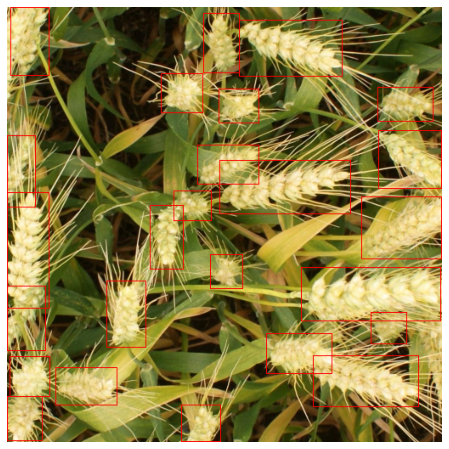

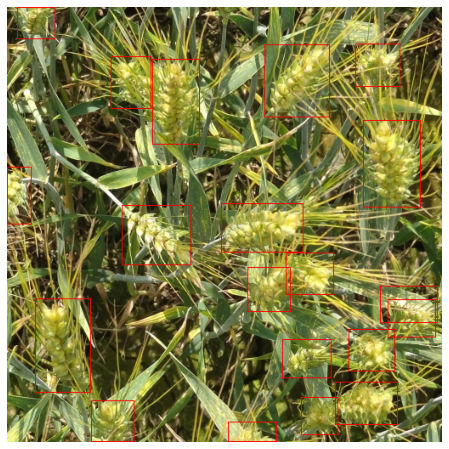

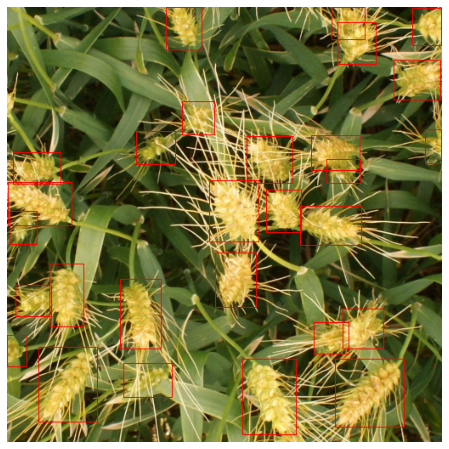

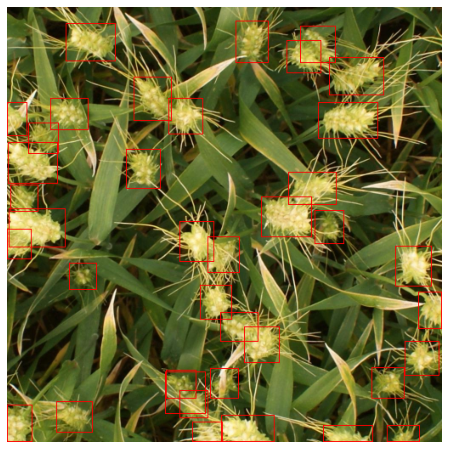

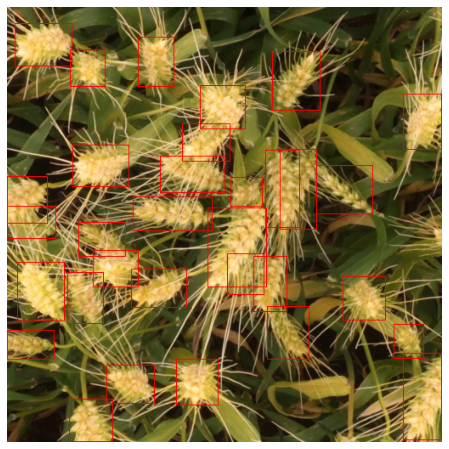

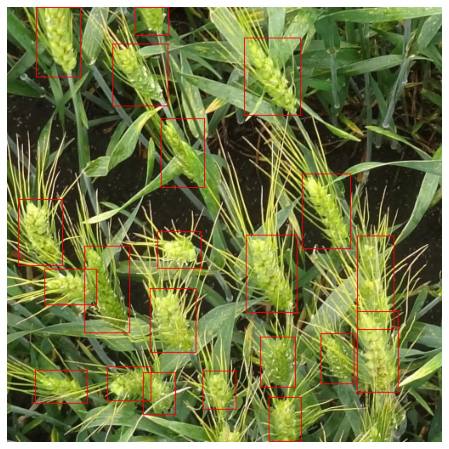

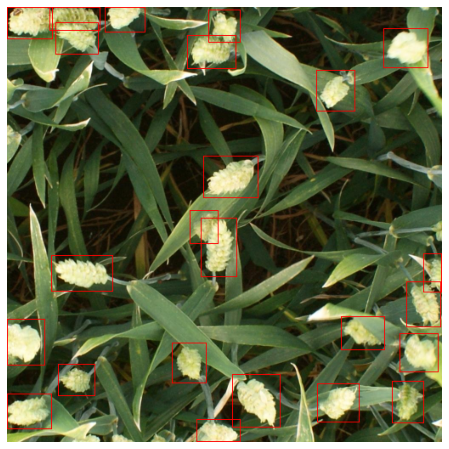

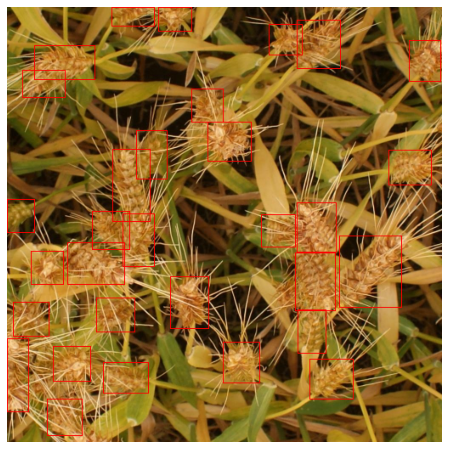

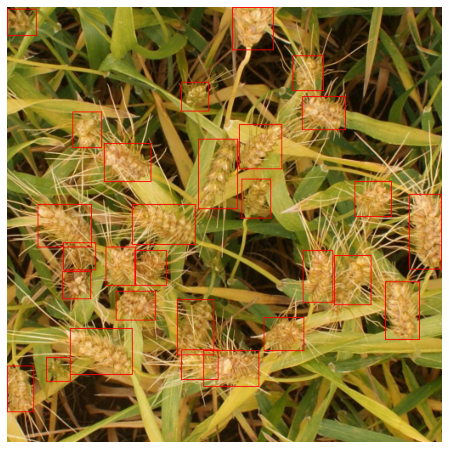

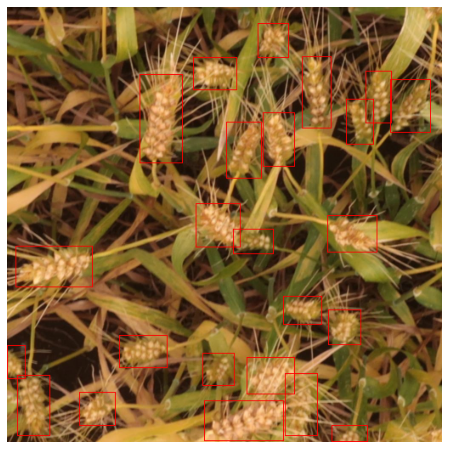

In [32]:
## show some pictures
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    

    predictions = make_tta_predictions(images)

    i = 0
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(sample)